<a href="https://colab.research.google.com/github/9-coding/ComputerVision_TeamProject/blob/main/ActiveLearning2/ActiveLearning2_modelCompare_dense161.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
from google.colab import drive
drive.mount('/content/gdrive/')

import os
# 각자 환경에서 이 부분만 변경하여 사용하면 됩니다.
os.chdir('/content/gdrive/MyDrive/CUB_200_2011_repackage_class50')

print(os.getcwd())



Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
/content/gdrive/MyDrive/CUB_200_2011_repackage_class50


In [16]:
# torch.cuda.empty_cache()

In [17]:
!nvidia-smi

Fri Nov 10 02:21:41 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0    32W /  70W |   9693MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [18]:
!ps aux | grep python

root          54  0.4  0.0      0     0 ?        Z    01:57   0:06 [python3] <defunct>
root          55  0.0  0.3  66448 51284 ?        S    01:57   0:00 python3 /usr/local/bin/colab-file
root         100  0.2  0.9 369088 122876 ?       Sl   01:57   0:04 /usr/bin/python3 /usr/local/bin/j
root         899 56.9 29.4 22910992 3913424 ?    Ssl  02:00  12:09 /usr/bin/python3 -m colab_kernel_
root         942  0.2  0.1 540336 14760 ?        Sl   02:00   0:03 /usr/bin/python3 /usr/local/lib/p
root       10266  0.0  0.0   7372  3456 ?        S    02:21   0:00 /bin/bash -c ps aux | grep python
root       10268  0.0  0.0   7372   280 ?        R    02:21   0:00 /bin/bash -c ps aux | grep python


In [19]:
#!sudo kill -9 315

In [20]:
!pip install wandb

In [21]:
!wandb login f9fc6c65de4904021a59f4c8c60b90961f6ec1fb

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [22]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import time
import torch
import torchvision.transforms as transforms
import torchvision.models as models
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from PIL import Image
import random

## wandb ###
import wandb
wandb.init(project='ActiveLearning2_modelCompare')
"""
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

set_seed(42)

"""
### GPU Setting ###
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print(DEVICE)

### Custom Dataset ###
class CUB2011(Dataset):
    def __init__(self, transform, mode='train'):
        self.transform = transform
        self.mode = mode
        self.image_folder = os.listdir(f'./datasets/{mode}')

    def __len__(self):
        return len(self.image_folder)

    def __getitem__(self, idx):
        img_path = self.image_folder[idx]
        img = Image.open(os.path.join('./datasets', self.mode, img_path)).convert('RGB')
        img = self.transform(img)
        label = int(img_path.split('_')[-1].split('.')[0])
        return (img, label)

cuda


In [23]:
### Data Augmentation ###
def transforms_func(transform):
  return transforms.Compose([
    transforms.Resize((448, 448)),
    transform,
    transforms.ToTensor(),
])

def transforms_resize_func(resize):
  return transforms.Compose([
    resize,
    transforms.ToTensor(),
])

ROTATION_DEGREE = 30
zoom_scale = (0.8, 1.2)
transforms_rotation = transforms_func(transforms.RandomRotation(degrees=ROTATION_DEGREE))
transforms_horizontal_flip = transforms_func(transforms.RandomHorizontalFlip(p=1.0))
transforms_zoom = transforms_func(transforms.RandomResizedCrop(448, scale=zoom_scale))

transforms_train = transforms_resize_func(transforms.Resize((448, 448)))
transforms_valtest = transforms_resize_func(transforms.Resize((448, 448)))
transforms_random_resized_crop = transforms_resize_func(transforms.RandomResizedCrop(448, scale=(0.8, 1.0)))

In [24]:
BATCH_SIZE = 8
EPOCH = 30
lr = 0.1

train_set = CUB2011(mode='train', transform=transforms_train)
train_set_rotation = CUB2011(mode='train', transform=transforms_rotation)
train_set_horizontal_flip = CUB2011(mode='train', transform=transforms_horizontal_flip)
train_set_randomcrop =  CUB2011(mode='train', transform=transforms_random_resized_crop)
train_set_zoom = CUB2011(mode='train', transform=transforms_zoom)

combined_train_set = ConcatDataset([train_set, train_set_horizontal_flip, train_set_zoom])

val_set = CUB2011(mode='valid', transform=transforms_valtest)
test_set = CUB2011(mode='test', transform=transforms_valtest)

train_loader = DataLoader(combined_train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

In [25]:
import torchsummary

### Model / Optimizer ###
model = models.densenet161(pretrained=True)

num_features = 1000

# Adjusting for augmentation
model.fc = nn.Linear(num_features, 50)
model = model.to(DEVICE)
optimizer = optim.SGD(model.parameters(), lr=lr)

print("densenet161")
print(model)
#print(torchsummary.summary(model, (3, 448, 448)))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet161_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet161_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


densenet161
DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [26]:
### Train/Evaluation ###
def train(model, train_loader, optimizer, epoch):
    model.train()
    for i, (image, target) in enumerate(train_loader):
        image, target = image.to(DEVICE), target.to(DEVICE)
        output = model(image)
        optimizer.zero_grad()
        train_loss = F.cross_entropy(output, target).to(DEVICE)
        train_loss.backward()
        optimizer.step()

        if i % 30 == 0:
            print(f'Train Epoch {epoch} [{i}/{len(train_loader)}]\tLoss: {train_loss.item():.6f}')
    return train_loss

def evaluate(model, val_loader):
    model.eval()
    eval_loss = 0
    correct = 0
    with torch.no_grad():
        for i, (image, target) in enumerate(val_loader):
            image, target = image.to(DEVICE), target.to(DEVICE)
            output = model(image)
            eval_loss += F.cross_entropy(output, target, reduction='sum').item()
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
        eval_loss /= len(val_loader.dataset)
        eval_accuracy = 100 * correct / len(val_loader.dataset)
        return eval_loss, eval_accuracy

Train Epoch 0 [0/885]	Loss: 8.395565
Train Epoch 0 [30/885]	Loss: 6.422139
Train Epoch 0 [60/885]	Loss: 5.407204
Train Epoch 0 [90/885]	Loss: 4.045057
Train Epoch 0 [120/885]	Loss: 4.563792
Train Epoch 0 [150/885]	Loss: 6.165107
Train Epoch 0 [180/885]	Loss: 4.582464
Train Epoch 0 [210/885]	Loss: 3.913408
Train Epoch 0 [240/885]	Loss: 5.038210
Train Epoch 0 [270/885]	Loss: 4.126630
Train Epoch 0 [300/885]	Loss: 4.244524
Train Epoch 0 [330/885]	Loss: 4.024979
Train Epoch 0 [360/885]	Loss: 3.976484
Train Epoch 0 [390/885]	Loss: 4.289543
Train Epoch 0 [420/885]	Loss: 3.721965
Train Epoch 0 [450/885]	Loss: 4.226551
Train Epoch 0 [480/885]	Loss: 4.199248
Train Epoch 0 [510/885]	Loss: 3.944503
Train Epoch 0 [540/885]	Loss: 3.692836
Train Epoch 0 [570/885]	Loss: 3.488866
Train Epoch 0 [600/885]	Loss: 4.037505
Train Epoch 0 [630/885]	Loss: 3.660208
Train Epoch 0 [660/885]	Loss: 4.335169
Train Epoch 0 [690/885]	Loss: 3.780952
Train Epoch 0 [720/885]	Loss: 3.328090
Train Epoch 0 [750/885]	Loss: 

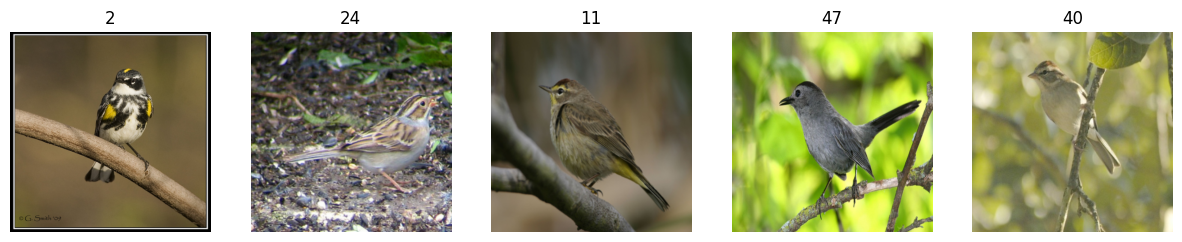

Epoch 0
Train Loss: 3.6327, Validation Loss: 4.0830, Validation Accuracy: 5.41%

Train Epoch 1 [0/885]	Loss: 3.879119
Train Epoch 1 [30/885]	Loss: 3.547614
Train Epoch 1 [60/885]	Loss: 4.129869
Train Epoch 1 [90/885]	Loss: 4.152196
Train Epoch 1 [120/885]	Loss: 3.561943
Train Epoch 1 [150/885]	Loss: 3.795082
Train Epoch 1 [180/885]	Loss: 4.013720
Train Epoch 1 [210/885]	Loss: 4.258809
Train Epoch 1 [240/885]	Loss: 3.613197
Train Epoch 1 [270/885]	Loss: 3.312184
Train Epoch 1 [300/885]	Loss: 3.773967
Train Epoch 1 [330/885]	Loss: 3.812507
Train Epoch 1 [360/885]	Loss: 3.835133
Train Epoch 1 [390/885]	Loss: 3.458811
Train Epoch 1 [420/885]	Loss: 4.719347
Train Epoch 1 [450/885]	Loss: 2.970307
Train Epoch 1 [480/885]	Loss: 3.447172
Train Epoch 1 [510/885]	Loss: 3.151100
Train Epoch 1 [540/885]	Loss: 3.527782
Train Epoch 1 [570/885]	Loss: 3.167868
Train Epoch 1 [600/885]	Loss: 4.469076
Train Epoch 1 [630/885]	Loss: 3.711493
Train Epoch 1 [660/885]	Loss: 3.533975
Train Epoch 1 [690/885]	Los

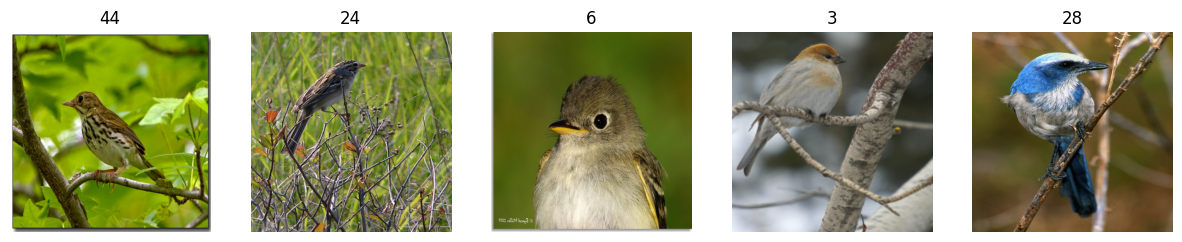

Epoch 1
Train Loss: 3.7805, Validation Loss: 3.7507, Validation Accuracy: 10.81%

Train Epoch 2 [0/885]	Loss: 3.587511
Train Epoch 2 [30/885]	Loss: 3.573422
Train Epoch 2 [60/885]	Loss: 3.472363
Train Epoch 2 [90/885]	Loss: 3.168175
Train Epoch 2 [120/885]	Loss: 3.661041
Train Epoch 2 [150/885]	Loss: 4.229738
Train Epoch 2 [180/885]	Loss: 4.232792
Train Epoch 2 [210/885]	Loss: 3.569015
Train Epoch 2 [240/885]	Loss: 3.408372
Train Epoch 2 [270/885]	Loss: 3.415964
Train Epoch 2 [300/885]	Loss: 3.224850
Train Epoch 2 [330/885]	Loss: 3.384737
Train Epoch 2 [360/885]	Loss: 3.452385
Train Epoch 2 [390/885]	Loss: 3.651606
Train Epoch 2 [420/885]	Loss: 3.336999
Train Epoch 2 [450/885]	Loss: 3.768705
Train Epoch 2 [480/885]	Loss: 3.389035
Train Epoch 2 [510/885]	Loss: 3.512089
Train Epoch 2 [540/885]	Loss: 3.772039
Train Epoch 2 [570/885]	Loss: 3.674024
Train Epoch 2 [600/885]	Loss: 3.407317
Train Epoch 2 [630/885]	Loss: 3.095202
Train Epoch 2 [660/885]	Loss: 4.176013
Train Epoch 2 [690/885]	Lo

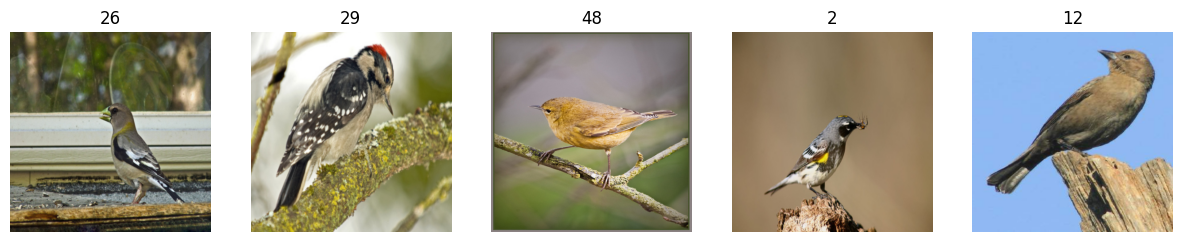

Epoch 2
Train Loss: 3.4416, Validation Loss: 6.3018, Validation Accuracy: 10.81%

Train Epoch 3 [0/885]	Loss: 3.656003
Train Epoch 3 [30/885]	Loss: 3.673070
Train Epoch 3 [60/885]	Loss: 3.197687
Train Epoch 3 [90/885]	Loss: 3.679794
Train Epoch 3 [120/885]	Loss: 3.649047
Train Epoch 3 [150/885]	Loss: 3.284753
Train Epoch 3 [180/885]	Loss: 3.239793
Train Epoch 3 [210/885]	Loss: 3.106508
Train Epoch 3 [240/885]	Loss: 4.104232
Train Epoch 3 [270/885]	Loss: 2.864527
Train Epoch 3 [300/885]	Loss: 2.911614
Train Epoch 3 [330/885]	Loss: 2.908953
Train Epoch 3 [360/885]	Loss: 3.507203
Train Epoch 3 [390/885]	Loss: 3.140212
Train Epoch 3 [420/885]	Loss: 3.118168
Train Epoch 3 [450/885]	Loss: 3.515692
Train Epoch 3 [480/885]	Loss: 3.359078
Train Epoch 3 [510/885]	Loss: 3.509480
Train Epoch 3 [540/885]	Loss: 3.504470
Train Epoch 3 [570/885]	Loss: 2.497925
Train Epoch 3 [600/885]	Loss: 2.322404
Train Epoch 3 [630/885]	Loss: 3.108408
Train Epoch 3 [660/885]	Loss: 2.640240
Train Epoch 3 [690/885]	Lo

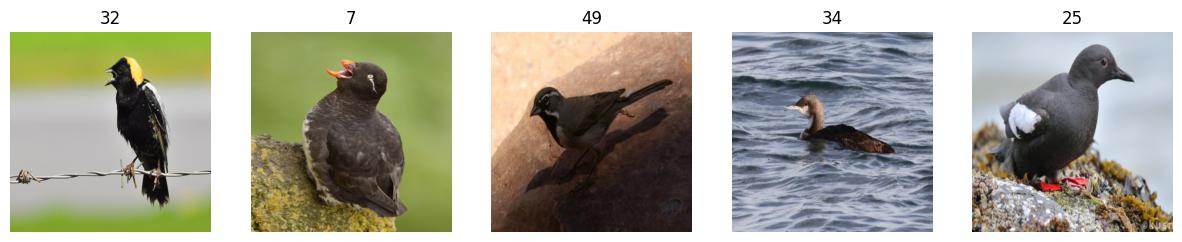

Epoch 3
Train Loss: 3.0889, Validation Loss: 4.0261, Validation Accuracy: 19.59%

Train Epoch 4 [0/885]	Loss: 2.400505
Train Epoch 4 [30/885]	Loss: 2.789650
Train Epoch 4 [60/885]	Loss: 4.299963
Train Epoch 4 [90/885]	Loss: 2.394153
Train Epoch 4 [120/885]	Loss: 2.315121
Train Epoch 4 [150/885]	Loss: 3.646296
Train Epoch 4 [180/885]	Loss: 1.987353
Train Epoch 4 [210/885]	Loss: 2.838334
Train Epoch 4 [240/885]	Loss: 2.163584
Train Epoch 4 [270/885]	Loss: 2.559033
Train Epoch 4 [300/885]	Loss: 3.435191
Train Epoch 4 [330/885]	Loss: 2.759767
Train Epoch 4 [360/885]	Loss: 2.697275
Train Epoch 4 [390/885]	Loss: 2.452929
Train Epoch 4 [420/885]	Loss: 2.721944
Train Epoch 4 [450/885]	Loss: 2.520524
Train Epoch 4 [480/885]	Loss: 3.001601
Train Epoch 4 [510/885]	Loss: 2.485281
Train Epoch 4 [540/885]	Loss: 4.335215
Train Epoch 4 [570/885]	Loss: 2.507322
Train Epoch 4 [600/885]	Loss: 3.107892
Train Epoch 4 [630/885]	Loss: 2.227754
Train Epoch 4 [660/885]	Loss: 1.865057
Train Epoch 4 [690/885]	Lo

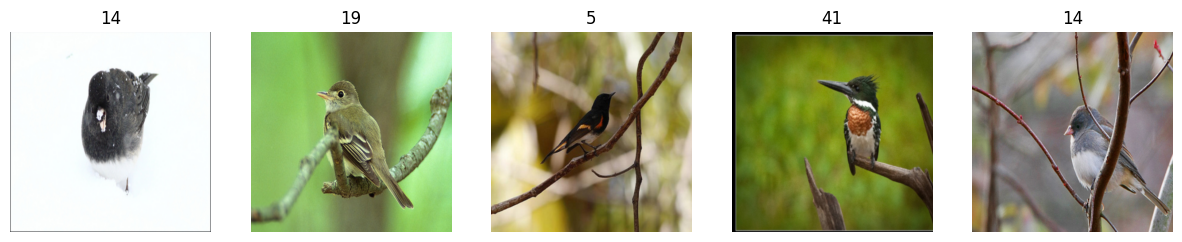

Epoch 4
Train Loss: 3.0512, Validation Loss: 3.0402, Validation Accuracy: 23.31%

Train Epoch 5 [0/885]	Loss: 2.631915
Train Epoch 5 [30/885]	Loss: 2.093994
Train Epoch 5 [60/885]	Loss: 1.905568
Train Epoch 5 [90/885]	Loss: 2.519309
Train Epoch 5 [120/885]	Loss: 2.743018
Train Epoch 5 [150/885]	Loss: 2.962318
Train Epoch 5 [180/885]	Loss: 1.995412
Train Epoch 5 [210/885]	Loss: 2.618280
Train Epoch 5 [240/885]	Loss: 2.757573
Train Epoch 5 [270/885]	Loss: 1.890188
Train Epoch 5 [300/885]	Loss: 1.922578
Train Epoch 5 [330/885]	Loss: 1.710384
Train Epoch 5 [360/885]	Loss: 2.197977
Train Epoch 5 [390/885]	Loss: 2.048835
Train Epoch 5 [420/885]	Loss: 2.085752
Train Epoch 5 [450/885]	Loss: 2.299888
Train Epoch 5 [480/885]	Loss: 2.740976
Train Epoch 5 [510/885]	Loss: 1.813640
Train Epoch 5 [540/885]	Loss: 2.988586
Train Epoch 5 [570/885]	Loss: 1.769068
Train Epoch 5 [600/885]	Loss: 1.830512
Train Epoch 5 [630/885]	Loss: 2.490582
Train Epoch 5 [660/885]	Loss: 2.524422
Train Epoch 5 [690/885]	Lo

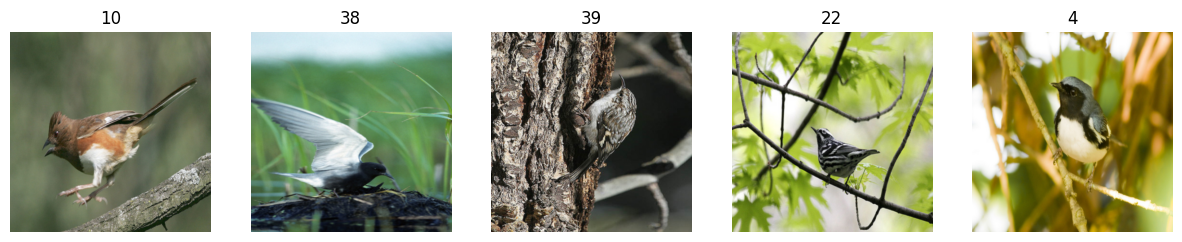

Epoch 5
Train Loss: 2.1560, Validation Loss: 2.7991, Validation Accuracy: 35.14%

Train Epoch 6 [0/885]	Loss: 1.559531
Train Epoch 6 [30/885]	Loss: 0.725997
Train Epoch 6 [60/885]	Loss: 1.649565
Train Epoch 6 [90/885]	Loss: 1.254916
Train Epoch 6 [120/885]	Loss: 2.085750
Train Epoch 6 [150/885]	Loss: 2.350869
Train Epoch 6 [180/885]	Loss: 1.606570
Train Epoch 6 [210/885]	Loss: 1.626087
Train Epoch 6 [240/885]	Loss: 1.683419
Train Epoch 6 [270/885]	Loss: 2.903914
Train Epoch 6 [300/885]	Loss: 1.772896
Train Epoch 6 [330/885]	Loss: 1.122702
Train Epoch 6 [360/885]	Loss: 1.918275
Train Epoch 6 [390/885]	Loss: 1.692690
Train Epoch 6 [420/885]	Loss: 2.501732
Train Epoch 6 [450/885]	Loss: 1.499474
Train Epoch 6 [480/885]	Loss: 2.378862
Train Epoch 6 [510/885]	Loss: 2.015924
Train Epoch 6 [540/885]	Loss: 2.751393
Train Epoch 6 [570/885]	Loss: 1.450038
Train Epoch 6 [600/885]	Loss: 2.089186
Train Epoch 6 [630/885]	Loss: 1.592543
Train Epoch 6 [660/885]	Loss: 2.238217
Train Epoch 6 [690/885]	Lo

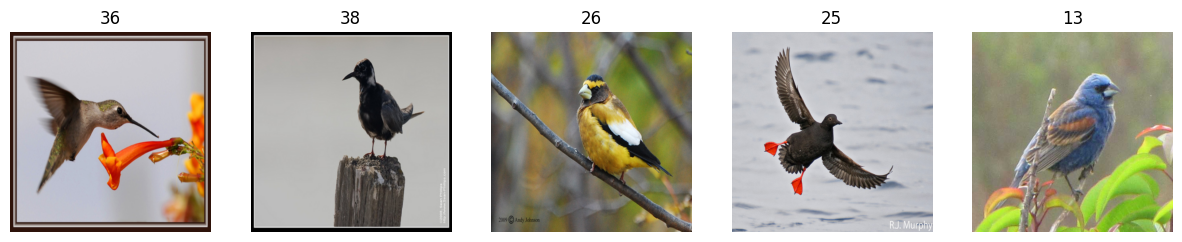

Epoch 6
Train Loss: 0.8726, Validation Loss: 2.8311, Validation Accuracy: 33.11%

Train Epoch 7 [0/885]	Loss: 2.036511
Train Epoch 7 [30/885]	Loss: 2.502936
Train Epoch 7 [60/885]	Loss: 1.759390
Train Epoch 7 [90/885]	Loss: 0.893578
Train Epoch 7 [120/885]	Loss: 1.620695
Train Epoch 7 [150/885]	Loss: 1.399055
Train Epoch 7 [180/885]	Loss: 0.899588
Train Epoch 7 [210/885]	Loss: 1.451934
Train Epoch 7 [240/885]	Loss: 1.991496
Train Epoch 7 [270/885]	Loss: 1.556423
Train Epoch 7 [300/885]	Loss: 2.258112
Train Epoch 7 [330/885]	Loss: 1.660414
Train Epoch 7 [360/885]	Loss: 0.865156
Train Epoch 7 [390/885]	Loss: 1.565200
Train Epoch 7 [420/885]	Loss: 2.129693
Train Epoch 7 [450/885]	Loss: 0.992909
Train Epoch 7 [480/885]	Loss: 1.666432
Train Epoch 7 [510/885]	Loss: 1.783062
Train Epoch 7 [540/885]	Loss: 1.444133
Train Epoch 7 [570/885]	Loss: 2.430812
Train Epoch 7 [600/885]	Loss: 1.858231
Train Epoch 7 [630/885]	Loss: 0.617759
Train Epoch 7 [660/885]	Loss: 1.589455
Train Epoch 7 [690/885]	Lo

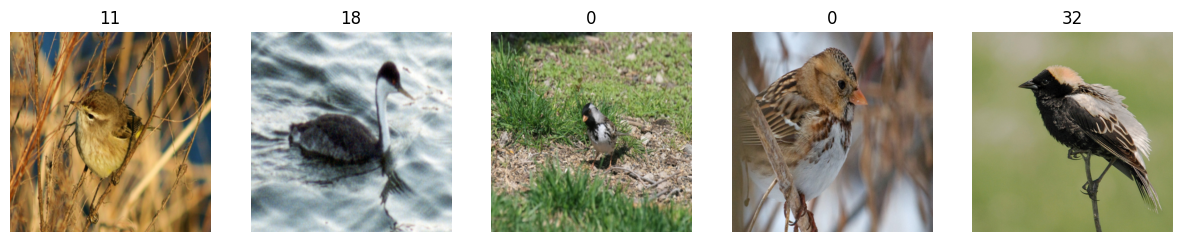

Epoch 7
Train Loss: 1.1303, Validation Loss: 2.2190, Validation Accuracy: 49.32%

Train Epoch 8 [0/885]	Loss: 1.055482
Train Epoch 8 [30/885]	Loss: 1.060277
Train Epoch 8 [60/885]	Loss: 0.574783
Train Epoch 8 [90/885]	Loss: 1.683089
Train Epoch 8 [120/885]	Loss: 1.311252
Train Epoch 8 [150/885]	Loss: 1.033271
Train Epoch 8 [180/885]	Loss: 0.980989
Train Epoch 8 [210/885]	Loss: 1.135872
Train Epoch 8 [240/885]	Loss: 1.007181
Train Epoch 8 [270/885]	Loss: 0.533028
Train Epoch 8 [300/885]	Loss: 1.244555
Train Epoch 8 [330/885]	Loss: 0.348308
Train Epoch 8 [360/885]	Loss: 2.179122
Train Epoch 8 [390/885]	Loss: 1.078788
Train Epoch 8 [420/885]	Loss: 1.425778
Train Epoch 8 [450/885]	Loss: 1.695201
Train Epoch 8 [480/885]	Loss: 0.426911
Train Epoch 8 [510/885]	Loss: 0.639624
Train Epoch 8 [540/885]	Loss: 2.401341
Train Epoch 8 [570/885]	Loss: 1.398799
Train Epoch 8 [600/885]	Loss: 0.310924
Train Epoch 8 [630/885]	Loss: 1.483018
Train Epoch 8 [660/885]	Loss: 0.635223
Train Epoch 8 [690/885]	Lo

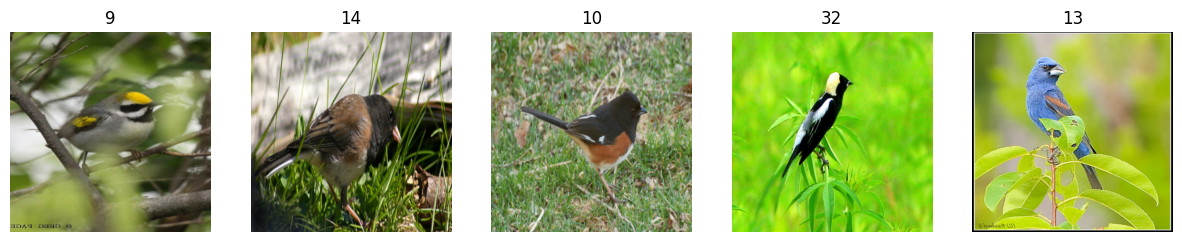

Epoch 8
Train Loss: 1.3531, Validation Loss: 1.8324, Validation Accuracy: 53.72%

Train Epoch 9 [0/885]	Loss: 0.971540
Train Epoch 9 [30/885]	Loss: 0.983571
Train Epoch 9 [60/885]	Loss: 1.358355
Train Epoch 9 [90/885]	Loss: 0.455394
Train Epoch 9 [120/885]	Loss: 1.166509
Train Epoch 9 [150/885]	Loss: 1.985785
Train Epoch 9 [180/885]	Loss: 1.671310
Train Epoch 9 [210/885]	Loss: 0.621222
Train Epoch 9 [240/885]	Loss: 0.658440
Train Epoch 9 [270/885]	Loss: 1.175704
Train Epoch 9 [300/885]	Loss: 0.306011
Train Epoch 9 [330/885]	Loss: 0.534967
Train Epoch 9 [360/885]	Loss: 0.844863
Train Epoch 9 [390/885]	Loss: 0.446628
Train Epoch 9 [420/885]	Loss: 1.513299
Train Epoch 9 [450/885]	Loss: 0.941522
Train Epoch 9 [480/885]	Loss: 1.483838
Train Epoch 9 [510/885]	Loss: 0.212237
Train Epoch 9 [540/885]	Loss: 0.656073
Train Epoch 9 [570/885]	Loss: 0.369558
Train Epoch 9 [600/885]	Loss: 0.625071
Train Epoch 9 [630/885]	Loss: 0.752317
Train Epoch 9 [660/885]	Loss: 0.300970
Train Epoch 9 [690/885]	Lo

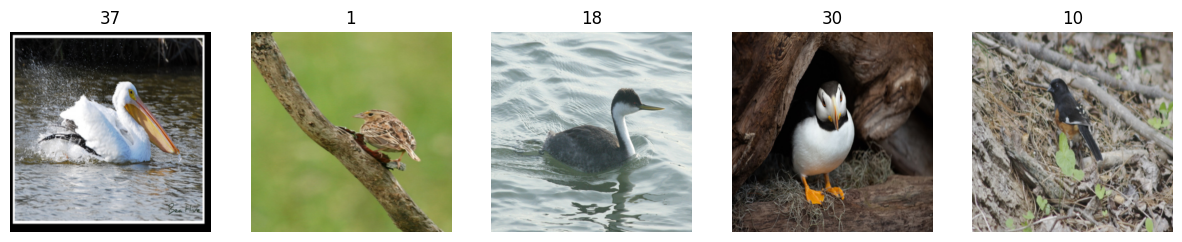

Epoch 9
Train Loss: 0.6741, Validation Loss: 1.7445, Validation Accuracy: 60.47%

Train Epoch 10 [0/885]	Loss: 0.849101
Train Epoch 10 [30/885]	Loss: 0.102442
Train Epoch 10 [60/885]	Loss: 0.393076
Train Epoch 10 [90/885]	Loss: 0.413764
Train Epoch 10 [120/885]	Loss: 0.643675
Train Epoch 10 [150/885]	Loss: 0.401160
Train Epoch 10 [180/885]	Loss: 1.226379
Train Epoch 10 [210/885]	Loss: 0.950405
Train Epoch 10 [240/885]	Loss: 0.721437
Train Epoch 10 [270/885]	Loss: 0.780544
Train Epoch 10 [300/885]	Loss: 0.138412
Train Epoch 10 [330/885]	Loss: 0.251967
Train Epoch 10 [360/885]	Loss: 0.613458
Train Epoch 10 [390/885]	Loss: 0.695618
Train Epoch 10 [420/885]	Loss: 0.695486
Train Epoch 10 [450/885]	Loss: 0.504633
Train Epoch 10 [480/885]	Loss: 0.833016
Train Epoch 10 [510/885]	Loss: 1.240144
Train Epoch 10 [540/885]	Loss: 0.405977
Train Epoch 10 [570/885]	Loss: 0.784790
Train Epoch 10 [600/885]	Loss: 0.638846
Train Epoch 10 [630/885]	Loss: 1.145867
Train Epoch 10 [660/885]	Loss: 0.354989
Tra

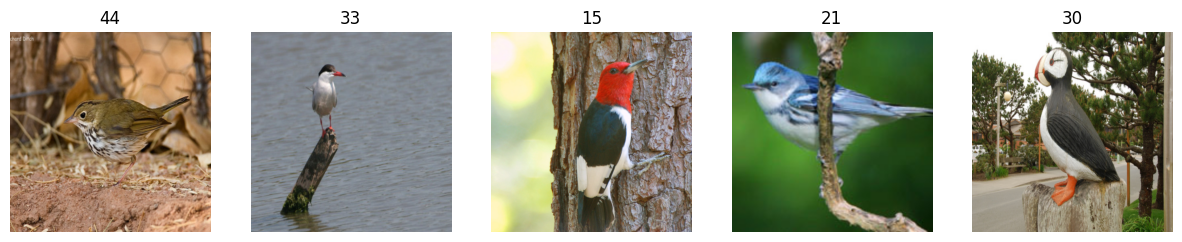

Epoch 10
Train Loss: 1.5104, Validation Loss: 2.1652, Validation Accuracy: 60.81%

Train Epoch 11 [0/885]	Loss: 0.358734
Train Epoch 11 [30/885]	Loss: 2.289395
Train Epoch 11 [60/885]	Loss: 0.701545
Train Epoch 11 [90/885]	Loss: 1.522050
Train Epoch 11 [120/885]	Loss: 0.810439
Train Epoch 11 [150/885]	Loss: 0.357116
Train Epoch 11 [180/885]	Loss: 0.891490
Train Epoch 11 [210/885]	Loss: 0.584568
Train Epoch 11 [240/885]	Loss: 0.405720
Train Epoch 11 [270/885]	Loss: 1.341696
Train Epoch 11 [300/885]	Loss: 0.796151
Train Epoch 11 [330/885]	Loss: 0.342381
Train Epoch 11 [360/885]	Loss: 0.145170
Train Epoch 11 [390/885]	Loss: 0.524257
Train Epoch 11 [420/885]	Loss: 1.339796
Train Epoch 11 [450/885]	Loss: 1.449197
Train Epoch 11 [480/885]	Loss: 0.779582
Train Epoch 11 [510/885]	Loss: 0.267755
Train Epoch 11 [540/885]	Loss: 0.409408
Train Epoch 11 [570/885]	Loss: 0.173448
Train Epoch 11 [600/885]	Loss: 1.652640
Train Epoch 11 [630/885]	Loss: 1.026513
Train Epoch 11 [660/885]	Loss: 0.247382
Tr

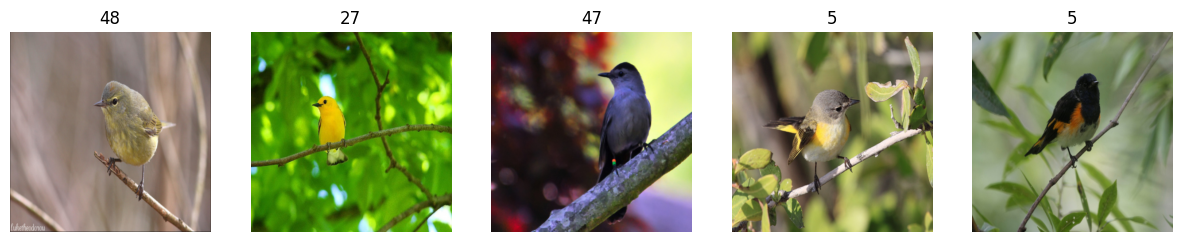

Epoch 11
Train Loss: 0.1089, Validation Loss: 1.3101, Validation Accuracy: 69.26%

Train Epoch 12 [0/885]	Loss: 0.271649
Train Epoch 12 [30/885]	Loss: 0.650752
Train Epoch 12 [60/885]	Loss: 0.642695
Train Epoch 12 [90/885]	Loss: 0.511459
Train Epoch 12 [120/885]	Loss: 0.526526
Train Epoch 12 [150/885]	Loss: 0.294783
Train Epoch 12 [180/885]	Loss: 0.303117
Train Epoch 12 [210/885]	Loss: 0.701724
Train Epoch 12 [240/885]	Loss: 0.334923
Train Epoch 12 [270/885]	Loss: 0.691917
Train Epoch 12 [300/885]	Loss: 0.064676
Train Epoch 12 [330/885]	Loss: 0.289286
Train Epoch 12 [360/885]	Loss: 0.424155
Train Epoch 12 [390/885]	Loss: 0.220355
Train Epoch 12 [420/885]	Loss: 0.100399
Train Epoch 12 [450/885]	Loss: 0.576267
Train Epoch 12 [480/885]	Loss: 0.200745
Train Epoch 12 [510/885]	Loss: 0.230592
Train Epoch 12 [540/885]	Loss: 0.321022
Train Epoch 12 [570/885]	Loss: 0.185177
Train Epoch 12 [600/885]	Loss: 0.468814
Train Epoch 12 [630/885]	Loss: 0.454138
Train Epoch 12 [660/885]	Loss: 0.903016
Tr

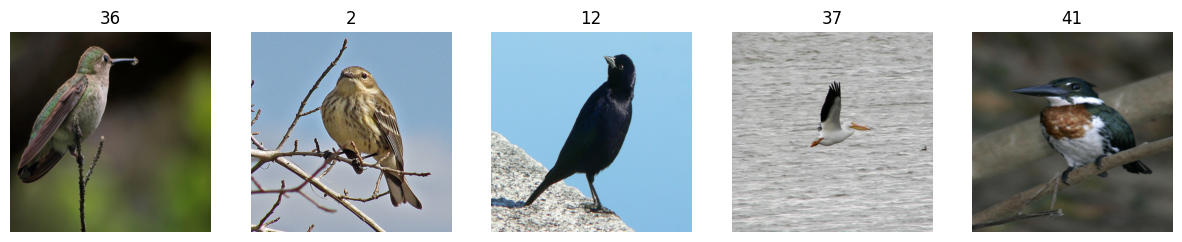

Epoch 12
Train Loss: 0.6551, Validation Loss: 1.5510, Validation Accuracy: 66.89%

Train Epoch 13 [0/885]	Loss: 0.130635
Train Epoch 13 [30/885]	Loss: 0.514686
Train Epoch 13 [60/885]	Loss: 0.236015
Train Epoch 13 [90/885]	Loss: 0.297837
Train Epoch 13 [120/885]	Loss: 0.210603
Train Epoch 13 [150/885]	Loss: 0.232009
Train Epoch 13 [180/885]	Loss: 0.929421
Train Epoch 13 [210/885]	Loss: 0.273597
Train Epoch 13 [240/885]	Loss: 0.078840
Train Epoch 13 [270/885]	Loss: 0.132499
Train Epoch 13 [300/885]	Loss: 1.048362
Train Epoch 13 [330/885]	Loss: 0.135284
Train Epoch 13 [360/885]	Loss: 0.149349
Train Epoch 13 [390/885]	Loss: 0.054965
Train Epoch 13 [420/885]	Loss: 0.457752
Train Epoch 13 [450/885]	Loss: 0.090864
Train Epoch 13 [480/885]	Loss: 0.265080
Train Epoch 13 [510/885]	Loss: 0.363051
Train Epoch 13 [540/885]	Loss: 0.136204
Train Epoch 13 [570/885]	Loss: 0.100720
Train Epoch 13 [600/885]	Loss: 0.057823
Train Epoch 13 [630/885]	Loss: 0.313431
Train Epoch 13 [660/885]	Loss: 0.394005
Tr

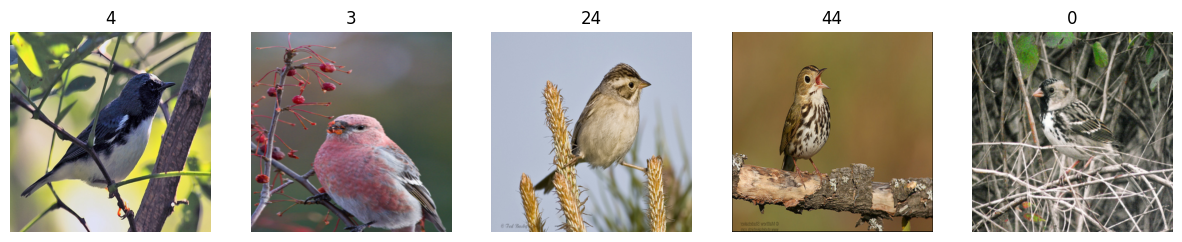

Epoch 13
Train Loss: 0.0529, Validation Loss: 1.5105, Validation Accuracy: 67.91%

Train Epoch 14 [0/885]	Loss: 0.338499
Train Epoch 14 [30/885]	Loss: 0.196685
Train Epoch 14 [60/885]	Loss: 0.168426
Train Epoch 14 [90/885]	Loss: 0.972274
Train Epoch 14 [120/885]	Loss: 0.117666
Train Epoch 14 [150/885]	Loss: 0.038004
Train Epoch 14 [180/885]	Loss: 0.092828
Train Epoch 14 [210/885]	Loss: 0.286114
Train Epoch 14 [240/885]	Loss: 0.240936
Train Epoch 14 [270/885]	Loss: 0.062662
Train Epoch 14 [300/885]	Loss: 0.137175
Train Epoch 14 [330/885]	Loss: 0.121610
Train Epoch 14 [360/885]	Loss: 0.250108
Train Epoch 14 [390/885]	Loss: 0.107251
Train Epoch 14 [420/885]	Loss: 0.061515
Train Epoch 14 [450/885]	Loss: 0.775488
Train Epoch 14 [480/885]	Loss: 0.382621
Train Epoch 14 [510/885]	Loss: 0.214329
Train Epoch 14 [540/885]	Loss: 0.171111
Train Epoch 14 [570/885]	Loss: 0.220042
Train Epoch 14 [600/885]	Loss: 1.152030
Train Epoch 14 [630/885]	Loss: 0.209159
Train Epoch 14 [660/885]	Loss: 0.127356
Tr

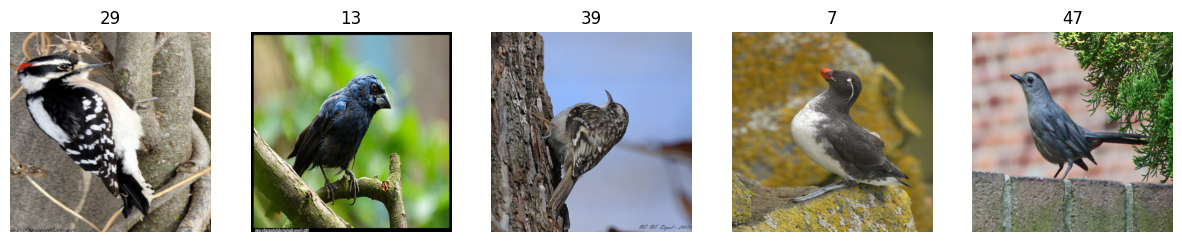

Epoch 14
Train Loss: 0.1614, Validation Loss: 1.7048, Validation Accuracy: 68.92%

Train Epoch 15 [0/885]	Loss: 0.102323
Train Epoch 15 [30/885]	Loss: 0.040522
Train Epoch 15 [60/885]	Loss: 0.044144
Train Epoch 15 [90/885]	Loss: 0.733020
Train Epoch 15 [120/885]	Loss: 0.012916
Train Epoch 15 [150/885]	Loss: 0.113990
Train Epoch 15 [180/885]	Loss: 0.250668
Train Epoch 15 [210/885]	Loss: 0.676823
Train Epoch 15 [240/885]	Loss: 0.313084
Train Epoch 15 [270/885]	Loss: 0.130360
Train Epoch 15 [300/885]	Loss: 0.663252
Train Epoch 15 [330/885]	Loss: 0.079642
Train Epoch 15 [360/885]	Loss: 0.192610
Train Epoch 15 [390/885]	Loss: 0.034799
Train Epoch 15 [420/885]	Loss: 0.061997
Train Epoch 15 [450/885]	Loss: 0.188442
Train Epoch 15 [480/885]	Loss: 0.383625
Train Epoch 15 [510/885]	Loss: 0.060080
Train Epoch 15 [540/885]	Loss: 0.058700
Train Epoch 15 [570/885]	Loss: 0.211207
Train Epoch 15 [600/885]	Loss: 0.532381
Train Epoch 15 [630/885]	Loss: 0.072173
Train Epoch 15 [660/885]	Loss: 0.432627
Tr

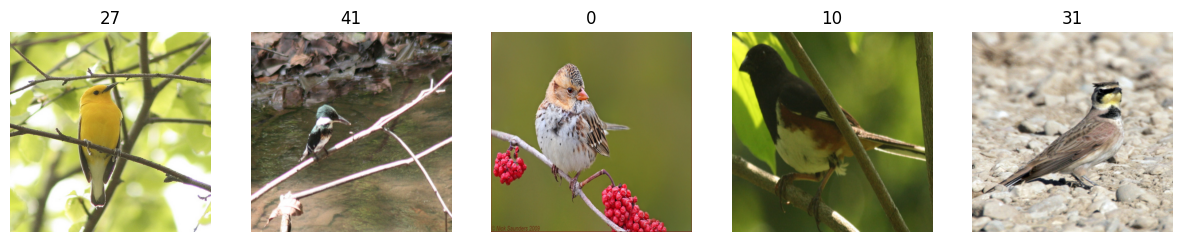

Epoch 15
Train Loss: 0.1962, Validation Loss: 1.5257, Validation Accuracy: 66.89%

Train Epoch 16 [0/885]	Loss: 0.302306
Train Epoch 16 [30/885]	Loss: 0.195332
Train Epoch 16 [60/885]	Loss: 0.201405
Train Epoch 16 [90/885]	Loss: 0.172456
Train Epoch 16 [120/885]	Loss: 0.060511
Train Epoch 16 [150/885]	Loss: 0.006032
Train Epoch 16 [180/885]	Loss: 0.384154
Train Epoch 16 [210/885]	Loss: 0.078818


In [ ]:
### Main ###
start = time.time()
best = 0

### wandb ###
wandb.watch(model, log="all")

for epoch in range(EPOCH):
    # With Augmentation
    train_loss = train(model, train_loader, optimizer, epoch)
    val_loss, val_accuracy = evaluate(model, val_loader)

    # Save best model
    if val_accuracy > best:
        best = val_accuracy
        torch.save(model.state_dict(), "./best_model.pth")

    # augmentation 적용한 이미지 보기
    dataiter = iter(train_loader)
    images, labels = dataiter.__next__()
    fig, axes = plt.subplots(1, 5, figsize=(15, 5))
    for i in range(5):
      image = images[i].numpy().transpose((1, 2, 0))
      image = np.clip(image, 0, 1)
      axes[i].imshow(image)
      axes[i].set_title(labels[i].item())
      axes[i].axis('off')
    plt.show()

    # Logging for model without augmentation
    wandb.log({
        'train_loss_with_aug': train_loss.item(),
        'val_loss_with_aug': val_loss,
        'val_accuracy_with_aug': val_accuracy,
    })

    print(f'Epoch {epoch}')
    print(f"Train Loss: {train_loss.item():.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
    print("")

# Test results
test_loss, test_accuracy = evaluate(model, test_loader)

wandb.log({'test_accuracy_with_aug': test_accuracy})

print(f'[FINAL with Augmentation] Test Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}%')

end = time.time()
elasped_time = end - start
print(f"Best Accuracy: {best:.2f}%")
print(f"Elapsed Time: {int(elasped_time/3600)}h, {int((elasped_time%3600)/60)}m, {int(elasped_time%60)}s")
print(f"time: {int (elasped_time/3600)}h, {int(elasped_time/60)}m, {int(elasped_time%60)}s")

In [ ]:
torch.save(model.state_dict(), "./model_state_dict.pt")

In [ ]:
!pip install grad-cam

In [ ]:
import copy
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet18
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
from matplotlib import pyplot as plt
"""
model = model_
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 50)
model = model.to(DEVICE)
optimizer = optim.SGD(model.parameters(), lr=lr)

model.load_state_dict(torch.load("model_state_dict.pt"))
model.eval()
"""

test_loss, test_accuracy = evaluate(model, test_loader)


print(f'Test Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}%')


def gradCAM_func(num):
  image_tensor, label = combined_train_set[num]
  transform = T.ToPILImage()
  rgb_img = transform(image_tensor)
  target_layers = [model.layer4[-1]]
  # Max min normalization
  rgb_img = (rgb_img - np.min(rgb_img)) / (np.max(rgb_img) - np.min(rgb_img))
  # Create an input tensor image for your model
  input_tensor = torchvision.transforms.functional.to_tensor(rgb_img).unsqueeze(0).float()
  # Note: input_tensor can be a batch tensor with several images!

  # Construct the CAM object once, and then re-use it on many images:
  cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)

  grayscale_cam = cam(input_tensor=input_tensor)

  # In this example grayscale_cam has only one image in the batch:
  grayscale_cam = grayscale_cam[0, :]
  visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
  Image.fromarray(visualization, 'RGB')
  fig, ax = plt.subplots(1, 2, figsize=(12, 6))

  # Display the image using imshow
  ax[0].imshow(rgb_img)
  ax[1].imshow(visualization)

  # Show the plot
  plt.title(label)
  plt.show()

  # Image.fromarray(visualization, 'RGB')

# 괄호 안에 아무 수나 넣고 테스트하면 됩니다.
for i in range(200):
  if i % 10 == 0:
    gradCAM_func(i)